Aggregating crime by each month


In [3]:
import os
import pandas as pd
from pathlib import Path

project_root = Path(os.getcwd()).resolve().parent
data_path = project_root / "data" / "processed" / "crime_data_processed.csv"
df = pd.read_csv(data_path)

df["Crime Count"] = pd.to_numeric(df["Crime Count"], errors="coerce")


cluster_df = (
    df.groupby(["State", "Year", "Month"])
    .agg(
        total_crime=("Crime Count", "sum"),
        unique_crimes=("Crime Description", "nunique"),
    )
    .reset_index()
)

print(cluster_df.head())

            State  Year  Month  total_crime  unique_crimes
0  Andhra Pradesh  2020      1       502300             20
1  Andhra Pradesh  2020      2       495300             20
2  Andhra Pradesh  2020      3       503400             20
3  Andhra Pradesh  2020      4       492300             20
4  Andhra Pradesh  2020      5       513800             20


In [2]:
# Sample output of above block
#       State        Year   Month      total_crime  unique_crimes
# 0  Andhra Pradesh  2020      1         14.0             12
# 1  Andhra Pradesh  2020      2          8.0              7
# 2  Andhra Pradesh  2020      3         14.0              8
# 3  Andhra Pradesh  2020      4          7.0              7
# 4  Andhra Pradesh  2020      5         18.0             11

Encode categorical features


In [4]:
from sklearn.preprocessing import LabelEncoder

df_model = df.copy()

state_encoder = LabelEncoder()
crime_encoder = LabelEncoder()

# Converting the STATE | CRIME DESC to numericals
df_model["State"] = state_encoder.fit_transform(df_model["State"])
df_model["Crime Description"] = crime_encoder.fit_transform(
    df_model["Crime Description"]
)

print(df_model.head())

   State  Year  Month  Crime Description  Crime Count
0      0  2020      1                  1        55200
1      0  2020      1                  2         9900
2      0  2020      1                  3        36500
3      0  2020      1                  4        38900
4      0  2020      1                  5        10600


Data Visualization Through Distribution


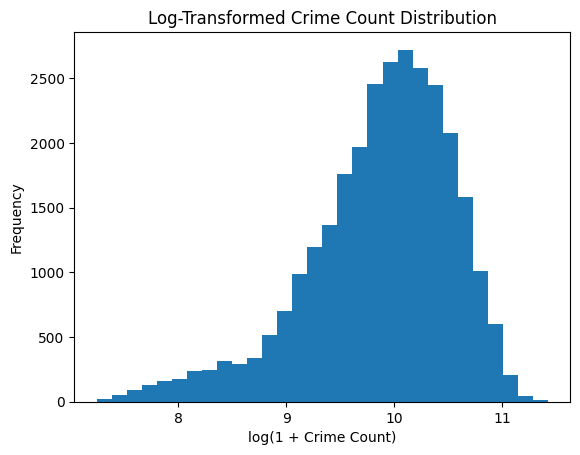

In [8]:
import numpy as np
import matplotlib.pyplot as plt

plt.hist(np.log1p(df_model["Crime Count"]), bins=30)
plt.title("Log-Transformed Crime Count Distribution")
plt.xlabel("log(1 + Crime Count)")
plt.ylabel("Frequency")
plt.show()

count    28944.000000
mean     23277.501382
std      13075.522721
min       1400.000000
25%      13400.000000
50%      21300.000000
75%      31200.000000
max      91200.000000
Name: Crime Count, dtype: float64


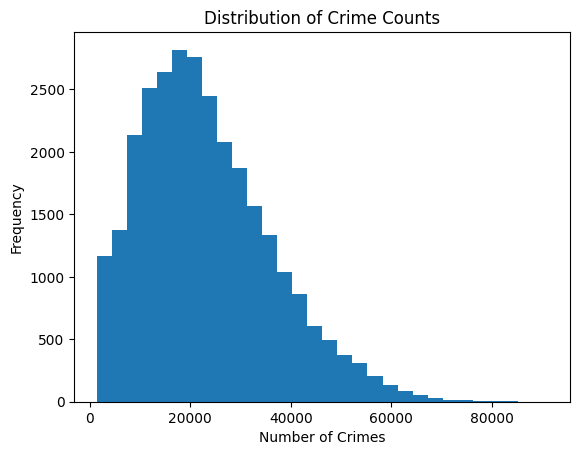

In [ ]:
import matplotlib.pyplot as plt

print(df_model["Crime Count"].describe())

# plt.hist(df_model["Crime Count"], bins=30)
plt.title("Distribution of Crime Counts")
plt.xlabel("Number of Crimes")
plt.ylabel("Frequency")
plt.show()

In [4]:
data_check = pd.crosstab(df_model['State'], df_model['Month'])

# Print the grid
print(data_check)

Month  1   2   3   4   5   6   7   8   9   10  11  12
State                                                
0      82  82  82  82  82  82  82  82  82  82  82  82
1      79  79  79  79  79  79  79  79  79  79  79  79
2      81  81  81  81  81  81  81  81  81  81  81  81
3      82  82  82  82  82  82  82  82  82  82  82  82
4      83  83  83  83  83  83  83  83  83  83  83  83
5      83  83  83  83  83  83  83  83  83  83  83  83
6      78  78  78  78  78  78  78  78  78  78  78  78
7      82  82  82  82  82  82  82  82  82  82  82  82
8      80  80  80  80  80  80  80  80  80  80  80  80
9      79  79  79  79  79  79  79  79  79  79  79  79
10     79  79  79  79  79  79  79  79  79  79  79  79
11     82  82  82  82  82  82  82  82  82  82  82  82
12     81  81  81  81  81  81  81  81  81  81  81  81
13     82  82  82  82  82  82  82  82  82  82  82  82
14     77  77  77  77  77  77  77  77  77  77  77  77
15     79  79  79  79  79  79  79  79  79  79  79  79
16     79  79  79  79  79  7

Trainer SVR - SUPPORT VECTOR REGRESSION (For Prediction)


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import FunctionTransformer
import numpy as np

df_clean = df.drop_duplicates().copy().dropna()
df_clean = df_clean.sort_values(by=['State', 'Crime Description', 'Year', 'Month'])

grouper = df_clean.groupby(['State', 'Crime Description'])['Crime Count']

df_clean['Lag_1'] = grouper.shift(1)  # Count last month
df_clean['Lag_3'] = grouper.shift(3)  # Count 3 months ago
df_clean['Rolling_Mean_3'] = grouper.transform(lambda x: x.shift(1).rolling(3).mean())
df_clean['Month_sin'] = np.sin(2 * np.pi * df_clean['Month'] / 12)
df_clean['Month_cos'] = np.cos(2 * np.pi * df_clean['Month'] / 12)
df_clean = df_clean.dropna()

# train_df = df_clean[(df_clean['Year'] >= 2020) & (df_clean['Year'] <= 2023)]

train_df = df_clean[df_clean['Year'] <= 2023] # change it to 2022 if need to test and check with 2023 as test set
# As the code is fine and working ignoing the test, we are training with complete data, ignoring tests
val_df   = df_clean[df_clean['Year'] == 2023]

# X_train = train_df[['State', 'Year', 'Month', 'Crime Description', 'Lag_1', 'Lag_3', 'Rolling_Mean_3']]
X_train = train_df[
    ['State', 'Year', 'Crime Description',
     'Lag_1', 'Lag_3', 'Rolling_Mean_3',
     'Month_sin', 'Month_cos']
]

y_train = train_df['Crime Count']

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), 
#          ['State', 'Crime Description']),
#         ('num', StandardScaler(), 
#          ['Year', 'Month', 'Lag_1', 'Lag_3', 'Rolling_Mean_3'])
#     ]
# )

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False),
         ['State', 'Crime Description']),

        ('num', StandardScaler(),
         ['Year', 'Lag_1', 'Lag_3', 'Rolling_Mean_3',
          'Month_sin', 'Month_cos'])
    ]
)

svr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SVR(
        kernel='rbf',
        C=100,
        gamma=0.005,
        epsilon=0.2
    ))
])
# model = TransformedTargetRegressor(
#     regressor=svr_pipeline,
#     transformer=StandardScaler() 
# )

log_transformer = FunctionTransformer(
    func=np.log1p,
    inverse_func=np.expm1,
    validate=False
)

model = TransformedTargetRegressor(
    regressor=svr_pipeline,
    transformer=log_transformer
)

print(f"Training SVR on {len(X_train)} rows up to 2023...")
model.fit(X_train, y_train)
print("Training Complete.")

# preds = model.predict(X_train)
# mse = mean_squared_error(y_train, preds)
# print(f"Training MSE: {mse:.2f}")
# X_val = val_df[['State', 'Year', 'Month', 'Crime Description',
                # 'Lag_1', 'Lag_3', 'Rolling_Mean_3']]
X_val = val_df[
    ['State', 'Year', 'Crime Description',
     'Lag_1', 'Lag_3', 'Rolling_Mean_3',
     'Month_sin', 'Month_cos']
]
y_val = val_df['Crime Count']

val_preds = model.predict(X_val)

val_mse  = mean_squared_error(y_val, val_preds)
val_rmse = np.sqrt(val_mse)
val_mape = np.mean(np.abs((y_val - val_preds) / y_val))

print(f"Validation RMSE: {val_rmse:.2f}")
print(f"Validation MAPE: {val_mape:.2%}")

Training SVR on 27054 rows up to 2023...
Training Complete.
Validation RMSE: 5637.61
Validation MAPE: 18.22%


In [6]:
val_df = val_df.copy()
val_df['Predicted'] = val_preds
val_df['AbsPctError'] = np.abs(val_df['Crime Count'] - val_df['Predicted']) / val_df['Crime Count']

print(
    val_df.groupby('Crime Description')['AbsPctError']
    .mean()
    .sort_values(ascending=False)
)

Crime Description
SEXUAL_ASSUALT         0.241751
KIDNAPPING             0.220875
TRAFFIC_VIOLATION      0.210034
BURGLARY               0.206351
COUNTER_FEITING        0.205537
DOMESTIC_VIOLENCE      0.205463
EXTORTION              0.192188
ILLEGAL_POSSESION      0.191828
ROBBERY                0.190864
VEHICLE_STOLEN         0.189316
ASSAULT                0.187727
FIREARM_OFFENCE        0.180759
CYBER_CRIME            0.174680
ARSON                  0.171047
HOMICIDE               0.166764
DRUG_OFFENCE           0.153655
FRAUD                  0.152696
IDENTITY_THEFT         0.152313
SHOP_LIFTING           0.147560
PUBLIC_INTOXICATION    0.144406
VANDALISM              0.132606
Name: AbsPctError, dtype: float64


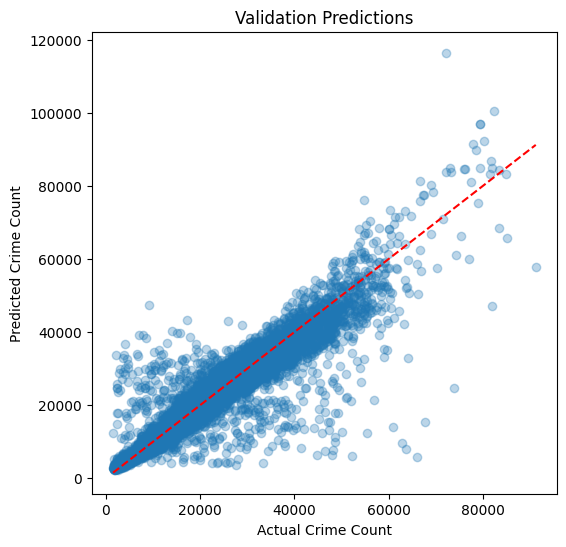

In [7]:
plt.figure(figsize=(6,6))
plt.scatter(y_val, val_preds, alpha=0.3)
plt.plot([y_val.min(), y_val.max()],
         [y_val.min(), y_val.max()], 'r--')
plt.xlabel("Actual Crime Count")
plt.ylabel("Predicted Crime Count")
plt.title("Validation Predictions")
plt.show()

Prediction Testing


In [7]:
""" The code below generated prediction for the whole year, so to predict it needs previous data 
    for year 2024 - it needs 2023 data of last maonth atleast.
 """

' The code below generated prediction for the whole year, so to predict it needs previous data \n    for year 2024 - it needs 2023 data of last maonth atleast.\n '

In [ ]:
import pandas as pd
import numpy as np

history_df = df[df['Year'] <= 2023].copy().sort_values(['State', 'Crime Description', 'Year', 'Month'])

unique_combos = df[['State', 'Crime Description']].drop_duplicates()

forecast_rows = []

print("Generating full 2024 lookup table (Recursive)...")

for month in range(1, 13):

    this_month_input = unique_combos.copy()
    this_month_input['Year'] = 2024
    this_month_input['Month'] = month
    this_month_input['Crime Count'] = 0 

    temp_df = pd.concat([history_df, this_month_input], ignore_index=True)
    temp_df = temp_df.sort_values(['State', 'Crime Description', 'Year', 'Month'])
    
    grouper = temp_df.groupby(['State', 'Crime Description'])['Crime Count']
    temp_df['Lag_1'] = grouper.shift(1)
    temp_df['Lag_3'] = grouper.shift(3)
    temp_df['Rolling_Mean_3'] = grouper.transform(lambda x: x.shift(1).rolling(3).mean())
    
    X_pred = temp_df[
        (temp_df['Year'] == 2024) & 
        (temp_df['Month'] == month)
    ].copy()
    
    # Handle NaNs
    features = ['State', 'Year', 'Month', 'Crime Description', 'Lag_1', 'Lag_3', 'Rolling_Mean_3']
    X_pred[features] = X_pred[features].fillna(0)
    
    preds = model.predict(X_pred[features])
    
    # Clean up for +ve Values
    preds = [max(0, int(round(p))) for p in preds]
    
    X_pred['Crime Count'] = preds
    forecast_rows.append(X_pred)
    
    # Add to history so next month can see these predictions
    history_df = pd.concat([history_df, X_pred[['State', 'Crime Description', 'Year', 'Month', 'Crime Count']]], ignore_index=True)
# SAVE THE LOOKUP TABLE
global_forecast = pd.concat(forecast_rows, ignore_index=True)
print(f"Done! Lookup Table Ready with {len(global_forecast)} rows.")
history_df.to_csv(project_root / "data" / "processed" / "crime_data_predicted_nb.csv", index=False)


Generating full 2024 lookup table (Recursive)...
Done! Lookup Table Ready with 3780 rows.


New NCRB

In [ ]:
import pandas as pd
import numpy as np

history_df = (
    df[df['Year'] <= 2023]
    .copy()
    .sort_values(['State', 'Crime Description', 'Year', 'Month'])
)

unique_combos = df[['State', 'Crime Description']].drop_duplicates()

forecast_rows = []

print("Generating full 2024 lookup table (Recursive)...")

for month in range(1, 13):

    this_month_input = unique_combos.copy()
    this_month_input['Year'] = 2024
    this_month_input['Month'] = month
    this_month_input['Crime Count'] = 0  

    this_month_input['Month_sin'] = np.sin(2 * np.pi * month / 12)
    this_month_input['Month_cos'] = np.cos(2 * np.pi * month / 12)

    temp_df = pd.concat([history_df, this_month_input], ignore_index=True)
    temp_df = temp_df.sort_values(['State', 'Crime Description', 'Year', 'Month'])


    grouper = temp_df.groupby(['State', 'Crime Description'])['Crime Count']
    temp_df['Lag_1'] = grouper.shift(1)
    temp_df['Lag_3'] = grouper.shift(3)
    temp_df['Rolling_Mean_3'] = grouper.transform(
        lambda x: x.shift(1).rolling(3).mean()
    )


    X_pred = temp_df[
        (temp_df['Year'] == 2024) &
        (temp_df['Month'] == month)
    ].copy()


    features = [
        'State', 'Year', 'Crime Description',
        'Lag_1', 'Lag_3', 'Rolling_Mean_3',
        'Month_sin', 'Month_cos'
    ]

    X_pred[features] = X_pred[features].fillna(0)


    preds = model.predict(X_pred[features])


    preds = np.maximum(0, np.round(preds).astype(int))

    X_pred['Crime Count'] = preds

    forecast_rows.append(X_pred)

    history_df = pd.concat(
        [
            history_df,
            X_pred[['State', 'Crime Description', 'Year', 'Month', 'Crime Count']]
        ],
        ignore_index=True
    )


global_forecast = pd.concat(forecast_rows, ignore_index=True)

print(f"Done! Lookup Table Ready with {len(global_forecast)} rows.")

global_forecast.to_csv(
    project_root / "data" / "processed" / "crime_data_predicted_2024.csv",
    index=False
)

Generating full 2024 lookup table (Recursive)...
Done! Lookup Table Ready with 7560 rows.


In [17]:
print(global_forecast)

               State  Year  Month  Crime Description  Crime Count  \
0     Andhra Pradesh  2024      1              ARSON        26302   
1     Andhra Pradesh  2024      1            ASSAULT        12153   
2     Andhra Pradesh  2024      1           BURGLARY         6562   
3     Andhra Pradesh  2024      1    COUNTER_FEITING        15356   
4     Andhra Pradesh  2024      1        CYBER_CRIME        16463   
...              ...   ...    ...                ...          ...   
7555     West Bengal  2024     12     SEXUAL_ASSUALT        20588   
7556     West Bengal  2024     12       SHOP_LIFTING         9206   
7557     West Bengal  2024     12  TRAFFIC_VIOLATION        26532   
7558     West Bengal  2024     12          VANDALISM         7957   
7559     West Bengal  2024     12     VEHICLE_STOLEN         5241   

         Month_sin  Month_cos    Lag_1    Lag_3  Rolling_Mean_3  
0     5.000000e-01   0.866025  30800.0  32000.0    29866.666667  
1     5.000000e-01   0.866025  12500.0 

In [10]:
def predict_crime_for_all_states(year, month, crime_type):
    """
    Takes Year, Month, and Crime Type.
    Returns the predicted count for EVERY state.
    """
    if 'global_forecast' not in globals():
        return pd.DataFrame([{"Error": "Please run the 'Lookup Table' generator code first."}])
    
    mask = (
        (global_forecast['Year'] == year) & 
        (global_forecast['Month'] == month) &
        (global_forecast['Crime Description'] == crime_type)
    )
    result_df = global_forecast[mask].copy()
    
    if result_df.empty:
        return pd.DataFrame([{"Error": f"No data found for '{crime_type}' in {month}/{year}. Check spelling."}])
    
    output = result_df[['State', 'Crime Count']].rename(
        columns={'Crime Count': 'Predicted Count'}
    )
    
    return output.sort_values(by='Predicted Count', ascending=False).reset_index(drop=True)


print("\n--- Prediction: Theft (Sep 2024) ---")
print(predict_crime_for_all_states(2024, 1, "ROBBERY").head(10))

print("\n--- Prediction: Arson (Jan 2024) ---")
print(predict_crime_for_all_states(2024, 1, "ARSON").head(15))


--- Prediction: Theft (Sep 2024) ---
            State  Predicted Count
0     Maharashtra                9
1       Karnataka                5
2         Gujarat                4
3       Telangana                4
4   Uttar Pradesh                4
5       Rajasthan                4
6           Delhi                4
7      Tamil Nadu                3
8          Punjab                3
9  Andhra Pradesh                3

--- Prediction: Arson (Jan 2024) ---
              State  Predicted Count
0       Maharashtra               15
1         Karnataka                6
2           Gujarat                5
3         Telangana                5
4     Uttar Pradesh                5
5        Tamil Nadu                4
6             Delhi                4
7       West Bengal                4
8            Punjab                3
9    Andhra Pradesh                2
10            Bihar                2
11  Jammu & Kashmir                2
12          Haryana                2
13        Rajasthan  

In [8]:
import os
import joblib

model_path = project_root / "models"
os.makedirs(model_path, exist_ok=True)

joblib.dump(model, model_path / "svr_model.pkl")
# joblib.dump(scaler_X, model_path / "scaler_svr.pkl")
joblib.dump(state_encoder, model_path / "state_encoder.pkl")
joblib.dump(crime_encoder, model_path / "crime_encoder.pkl")

print("All files saved successfully in 'models/' folder!")

All files saved successfully in 'models/' folder!
